In [16]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.datasets import load_iris, load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

import tensorflow as tf

from myANN import MyANN
from myNetworkLayers import DenseLayer

from PIL import Image

In [17]:
def load_iris_data():
    data = load_iris()
    
    inputs = data['data']
    outputs, output_names = data['target'], data['target_names']
    
    feature_names = list(data['feature_names'])
    feature1 = [feat[feature_names.index('sepal length (cm)')] for feat in inputs]
    feature2 = [feat[feature_names.index('petal length (cm)')] for feat in inputs]
    
    inputs = [[f1, f2] for f1, f2 in zip(feature1, feature2)]
    
    return inputs, outputs, output_names

In [18]:
def split_data(inputs, outputs):
    np.random.seed(5)
    indexes = [i for i in range(len(inputs))]
    trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
    testSample = [i for i in indexes  if not i in trainSample]

    trainInputs = [inputs[i] for i in trainSample]
    trainOutputs = [outputs[i] for i in trainSample]
    testInputs = [inputs[i] for i in testSample]
    testOutputs = [outputs[i] for i in testSample]
    
    return trainInputs, trainOutputs, testInputs, testOutputs


def normalisation(train_data, test_data):
    if(np.array(train_data).ndim == 2 or np.array(train_data).ndim == 1):
        scaler = StandardScaler()
        
        if not isinstance(train_data[0], list):
            train_data = [[el] for el in train_data]
            test_data = [[el] for el in test_data]
            
            scaler.fit(train_data)
            norm_train_data = scaler.transform(train_data)
            norm_test_data = scaler.transform(test_data)
            
            norm_train_data = [el[0] for el in norm_train_data]
            norm_test_data = [el[0] for el in norm_test_data]
        else:
            scaler.fit(train_data)
            norm_train_data = scaler.transform(train_data)
            norm_test_data = scaler.transform(test_data)
        
        return norm_train_data, norm_test_data

    norm_train_data = np.array(train_data) / 255.0
    norm_test_data = np.array(test_data) / 255.0
    return norm_train_data, test_data

In [19]:
def data_2_features_more_classes(inputs, outputs, output_names):
    labels, no_data = set(outputs), len(inputs)
    
    for crt_label in labels:
        x = [inputs[i][0] for i in range(no_data) if outputs[i] == crt_label]
        y = [inputs[i][1] for i in range(no_data) if outputs[i] == crt_label]
        plt.scatter(x, y, label = output_names[crt_label])
    
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()
    

def plot_data_distribution(outputs, output_names, title):
    bins = range(len(output_names) + 1)
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    
    plt.hist(outputs, bins, rwidth = 0.8)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), output_names)
    
    plt.title(title)
    plt.show()
    
def plot_predicted_over_test(predicted, test, output_names, title):
    bins = range(len(output_names) + 1)
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    
    predicted_counts = [predicted.tolist().count(i) for i in range(len(output_names))]
    test_counts = [test.count(i) for i in range(len(output_names))]
    
    x = np.arange(len(output_names))
    
    plt.bar(x, test_counts, bin_w / 2, label='Test', color='blue')
    plt.bar(x, predicted_counts, bin_w / 2, label='Predicted', color='red')
    
    plt.xticks(x, output_names)

    plt.title(title)
    plt.legend()
    plt.show()
    
def plot_confusion_matrix(cm, output_names, title):
    classes = output_names
    
    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap='Blues')
    plt.title('Confusion Matrix - ' + title)
    plt.colorbar()
    
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)
    
    text_format = 'd'
    threshold = cm.max() / 2
    
    for row, column in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(column, row, format(cm[row, column], text_format),
                 horizontalalignment = 'center',
                 color='white' if cm[row, column] > threshold else 'black')
    
    plt.ylabel('Truth Label')
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    
    plt.show()

    

In [39]:
def train_model(classifier : MLPClassifier, X_train, y_train, X_test):
    classifier.fit(X_train, y_train)
    return classifier.predict(X_test)

def build_my_network(classifier: MyANN, input_size, output_size):
    classifier.add(DenseLayer(input_size, 50))
    classifier.add(DenseLayer(50, 50))
    classifier.add(DenseLayer(50, output_size))
    
def cnn_using_tool(X_train, y_train, X_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = tf.keras.utils.to_categorical(y_train)
    
    # classifier = tf.keras.Sequential([
    #     tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(256, 256, 3)),
    #     tf.keras.layers.MaxPooling2D(),
    #     tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    #     tf.keras.layers.MaxPooling2D(),
    #     tf.keras.layers.Dropout(0.25),
    #     tf.keras.layers.Flatten(),
    #     tf.keras.layers.Dense(2, activation='softmax')
    # ])
    
    # classifier = tf.keras.Sequential([
    #     tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
    #     tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    #     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #     tf.keras.layers.Dropout(0.25),

    #     tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    #     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    #     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #     tf.keras.layers.Dropout(0.25),

    #     tf.keras.layers.Flatten(),
    #     tf.keras.layers.Dense(512, activation='relu'),
    #     tf.keras.layers.Dropout(0.5),
    #     tf.keras.layers.Dense(2, activation='softmax')
    # ])
    
    classifier = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    classifier.summary()
    classifier.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    
    classifier.fit(X_train, y_train, epochs=25, batch_size=256)
    return np.argmax(classifier.predict(X_test), axis=1)

In [21]:
def evaluate_multi_class(real_labels, computed_labels, label_names):
    cm = confusion_matrix(real_labels, computed_labels)
    
    accuracy = sum([cm[i][i] for i in range(len(label_names))]) / len(real_labels)
    
    precision, recall = {}, {}
    for i in range(len(label_names)):
        precision[label_names[i]] = cm[i][i] / sum([cm[j][i] for j in range(len(label_names))])
        recall[label_names[i]] = cm[i][i] / sum([cm[i][j] for j in range(len(label_names))])
    
    return cm, accuracy, precision, recall

In [22]:
def main_iris(classifier):
    iris_inputs, iris_outputs, iris_outputs_names = load_iris_data()
    
    X_train, y_train, X_test, y_test = split_data(iris_inputs, iris_outputs)
    X_train, X_test = normalisation(X_train, X_test)
    
    plot_data_distribution(y_train, iris_outputs_names, "Training Outputs")
    data_2_features_more_classes(X_train, y_train, iris_outputs_names)
    
    if isinstance(classifier, MyANN):
        build_my_network(classifier, len(X_train[0]), len(iris_outputs_names))
    
    predicted_outputs = train_model(classifier, X_train, y_train, X_test)
    plot_predicted_over_test(predicted_outputs, y_test, iris_outputs_names, "Predicted vs. Test")
    
    cm, acc, prec, rec = evaluate_multi_class(np.array(y_test), predicted_outputs, iris_outputs_names)
    plot_confusion_matrix(cm, iris_outputs_names, 'Iris Classification')
    
    print(f'Accuracy: {acc}')
    print(f'Precision: {prec}')
    print(f'Recall: {rec}')



In [23]:
def load_digits_data():
    data = load_digits()
    
    inputs, outputs = data.images, data['target']
    output_names = data['target_names']
    
    no_data = len(inputs)
    permutation = np.random.permutation(no_data)
    
    inputs, outputs = inputs[permutation], outputs[permutation]
    
    return np.array(inputs), outputs, output_names

In [24]:
def flatten_matrix(mat):
    x = []
    if (np.array(mat).ndim == 2):
        for line in mat:
            for el in line:
                x.append(el)
    elif (np.array(mat).ndim == 3):
        for line in mat:
            for pixel in line:
                for el in pixel:
                    x.append(el)
    return x

In [32]:
def main_digits(classifier):
    digit_inputs, digit_outputs, digit_output_names = load_digits_data()
    
    X_train, y_train, X_test, y_test = split_data(digit_inputs, digit_outputs)
    plot_data_distribution(y_train, digit_output_names, "Training Outputs")
        
    X_train_flatten = [flatten_matrix(el) for el in X_train]
    X_test_flatten = [flatten_matrix(el) for el in X_test]

    X_train, X_test = normalisation(X_train_flatten, X_test_flatten)
    
    if isinstance(classifier, MyANN):
        build_my_network(classifier, len(X_train[0]), len(digit_output_names))
        
    predicted_outputs = train_model(classifier, X_train, y_train, X_test)
    plot_predicted_over_test(predicted_outputs, y_test, digit_output_names, "Predicted vs. Test")
    
    cm, acc, prec, rec = evaluate_multi_class(np.array(y_test), predicted_outputs, digit_output_names)
    plot_confusion_matrix(cm, digit_output_names, 'Digit Classification')
    
    
    print(f'Accuracy: {acc}')
    print(f'Precision: {prec}')
    print(f'Recall: {rec}')
    

In [26]:
def resize_image(image: Image, width=256, height=256):
    return image.resize((width, height))

def apply_sepia(path: str = "./images/"):
    for i in range(0, 2054):
        image_path = path + "sample_" + str(i + 1) + ".jpg"
        image = Image.open(image_path)
        
        image = resize_image(image)
        
        if (i % 2 == 0):
            w, h = image.size
            pixels = image.load()
            
            for py in range(h):
                for px in range(w):
                    r, g, b = image.getpixel((px, py))
                    
                    tr = int(0.393 * r + 0.769 * g + 0.189 * b)
                    tg = int(0.349 * r + 0.686 * g + 0.168 * b)
                    tb = int(0.272 * r + 0.534 * g + 0.131 * b) 
                    
                    if tr > 255:
                        tr = 255

                    if tg > 255:
                        tg = 255

                    if tb > 255:
                        tb = 255
                        
                    pixels[px, py] = (tr, tg, tb)
        
        image.save(image_path)
        image.close()
        
def load_sepia_data(path: str = "./images/", n=100):
    inputs = []
    
    outputs = [1 if i % 2 == 0 else 0 for i in range(n)]
    output_names = ['normal', 'sepia']

    for i in range(0, n):
        image_path = path + "sample_" + str(i + 1) + ".jpg"
        image = Image.open(image_path)
        inputs.append(np.array(image))
        
        image.close()
        
    inputs = np.array(inputs)
    return inputs, outputs, output_names

In [41]:
def main_sepia(classifier):
    sepia_inputs, sepia_outputs, sepia_output_names = load_sepia_data(n=400)
    
    X_train, y_train, X_test, y_test = split_data(sepia_inputs.tolist(), sepia_outputs)
    plot_data_distribution(y_train, sepia_output_names, "Training Outputs")
        
    X_train_flatten = [flatten_matrix(el) for el in X_train]
    X_test_flatten = [flatten_matrix(el) for el in X_test]

    X_train, X_test = normalisation(X_train_flatten, X_test_flatten)
    
    if isinstance(classifier, MyANN):
        build_my_network(classifier, len(X_train[0]), len(sepia_output_names))
        
    predicted_outputs = train_model(classifier, X_train, y_train, X_test)
    plot_predicted_over_test(predicted_outputs, y_test, sepia_output_names, "Predicted vs. Test")
    
    cm, acc, prec, rec = evaluate_multi_class(np.array(y_test), predicted_outputs, sepia_output_names)
    plot_confusion_matrix(cm, sepia_output_names, 'Digit Classification')
    
    
    print(f'Accuracy: {acc}')
    print(f'Precision: {prec}')
    print(f'Recall: {rec}')

def main_sepia_cnn():
    sepia_inputs, sepia_outputs, sepia_output_names = load_sepia_data(n=200)
    
    X_train, y_train, X_test, y_test = split_data(sepia_inputs, sepia_outputs)
    plot_data_distribution(y_train, sepia_output_names, "Training Outputs")

    X_train, X_test = normalisation(X_train, X_test)
    
    predicted_outputs = cnn_using_tool(X_train, y_train, X_test)
    plot_predicted_over_test(predicted_outputs, y_test, sepia_output_names, "Predicted vs. Test")
    
    cm, acc, prec, rec = evaluate_multi_class(np.array(y_test), predicted_outputs, sepia_output_names)
    plot_confusion_matrix(cm, sepia_output_names, 'Digit Classification')
    
    print(f"Accuracy: {acc}")
    print(f"Recall: {rec}")
    print(f"Precision: {prec}")
    

In [28]:
clf = MLPClassifier(hidden_layer_sizes=(5, ), activation='relu', max_iter=1000, solver='sgd',
                          verbose=10, random_state=42, learning_rate_init=0.01)
my_clf = MyANN(epochs=10)

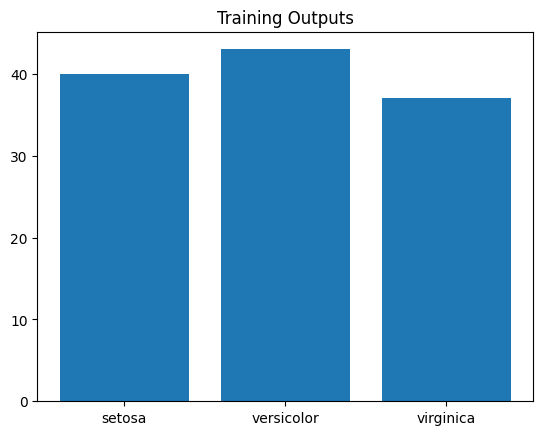

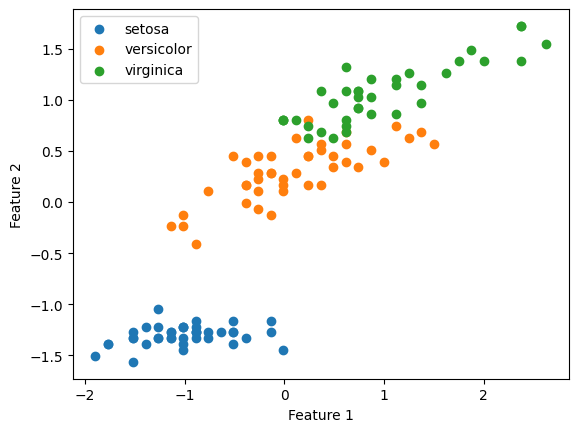

Iteration 1, loss = 1.06344551
Iteration 2, loss = 1.05843899
Iteration 3, loss = 1.05141418
Iteration 4, loss = 1.04268734
Iteration 5, loss = 1.03256004
Iteration 6, loss = 1.02131387
Iteration 7, loss = 1.00923355
Iteration 8, loss = 0.99660670
Iteration 9, loss = 0.98362882
Iteration 10, loss = 0.97048035
Iteration 11, loss = 0.95728540
Iteration 12, loss = 0.94418446
Iteration 13, loss = 0.93137147
Iteration 14, loss = 0.91890426
Iteration 15, loss = 0.90675953
Iteration 16, loss = 0.89501665
Iteration 17, loss = 0.88370929
Iteration 18, loss = 0.87281649
Iteration 19, loss = 0.86236020
Iteration 20, loss = 0.85235704
Iteration 21, loss = 0.84277526
Iteration 22, loss = 0.83357607
Iteration 23, loss = 0.82474812
Iteration 24, loss = 0.81627839
Iteration 25, loss = 0.80812800
Iteration 26, loss = 0.80031271
Iteration 27, loss = 0.79278264
Iteration 28, loss = 0.78551067
Iteration 29, loss = 0.77848390
Iteration 30, loss = 0.77169030
Iteration 31, loss = 0.76512614
Iteration 32, los

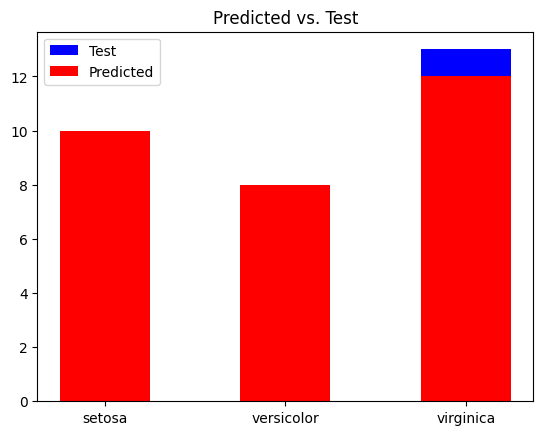

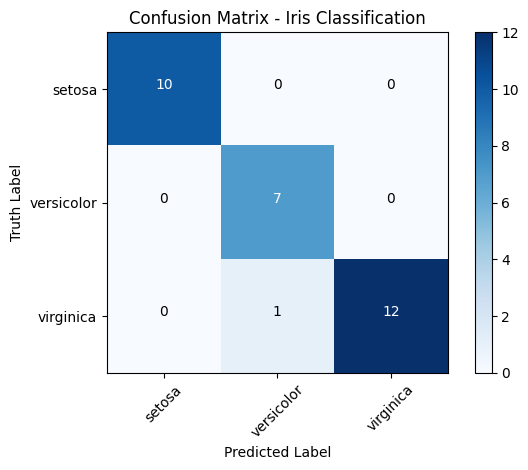

Accuracy: 0.9666666666666667
Precision: {'setosa': 1.0, 'versicolor': 0.875, 'virginica': 1.0}
Recall: {'setosa': 1.0, 'versicolor': 1.0, 'virginica': 0.9230769230769231}


In [29]:
main_iris(clf)

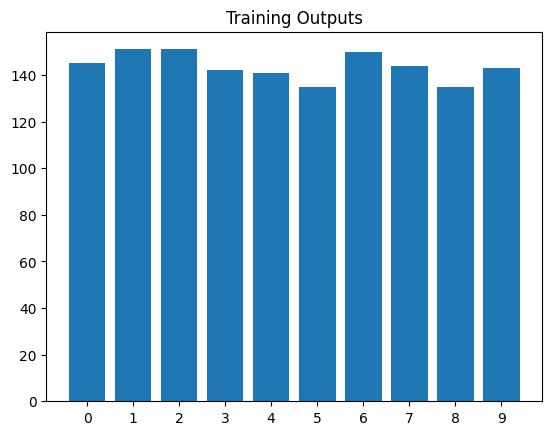

Iteration 1, loss = 2.60725790
Iteration 2, loss = 2.22281796
Iteration 3, loss = 1.91349767
Iteration 4, loss = 1.72781209
Iteration 5, loss = 1.59596537
Iteration 6, loss = 1.48546288
Iteration 7, loss = 1.38396435
Iteration 8, loss = 1.29492464
Iteration 9, loss = 1.22119978
Iteration 10, loss = 1.15820864
Iteration 11, loss = 1.09903612
Iteration 12, loss = 1.04240891
Iteration 13, loss = 0.98678592
Iteration 14, loss = 0.93446574
Iteration 15, loss = 0.88719615
Iteration 16, loss = 0.84405241
Iteration 17, loss = 0.80703481
Iteration 18, loss = 0.77250477
Iteration 19, loss = 0.74139979
Iteration 20, loss = 0.71210549
Iteration 21, loss = 0.68587948
Iteration 22, loss = 0.66181315
Iteration 23, loss = 0.63875594
Iteration 24, loss = 0.61724983
Iteration 25, loss = 0.59821922
Iteration 26, loss = 0.58090567
Iteration 27, loss = 0.56500552
Iteration 28, loss = 0.55018319
Iteration 29, loss = 0.53591416
Iteration 30, loss = 0.52203160
Iteration 31, loss = 0.50909504
Iteration 32, los

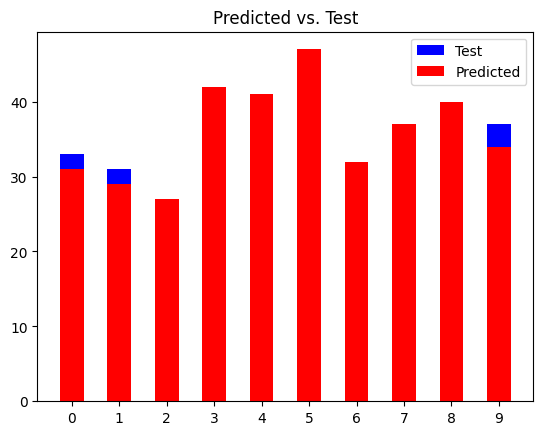

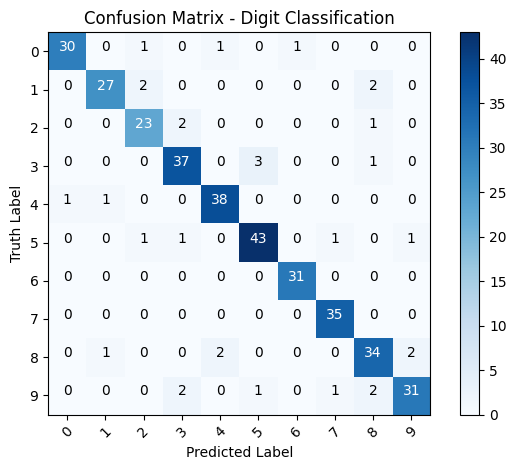

Accuracy: 0.9138888888888889
Precision: {0: 0.967741935483871, 1: 0.9310344827586207, 2: 0.8518518518518519, 3: 0.8809523809523809, 4: 0.926829268292683, 5: 0.9148936170212766, 6: 0.96875, 7: 0.9459459459459459, 8: 0.85, 9: 0.9117647058823529}
Recall: {0: 0.9090909090909091, 1: 0.8709677419354839, 2: 0.8846153846153846, 3: 0.9024390243902439, 4: 0.95, 5: 0.9148936170212766, 6: 1.0, 7: 1.0, 8: 0.8717948717948718, 9: 0.8378378378378378}


In [33]:
main_digits(clf)

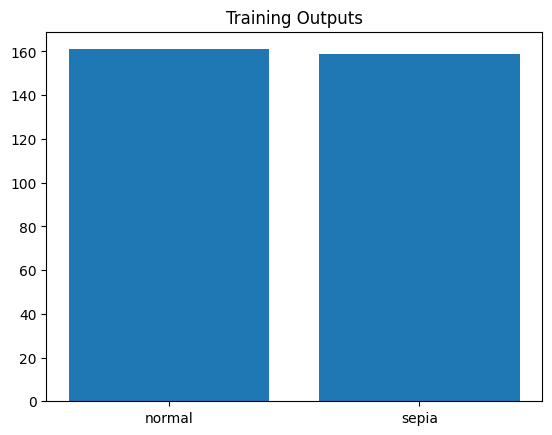

Iteration 1, loss = 3.82361579
Iteration 2, loss = 8.80450253
Iteration 3, loss = 4.52098915
Iteration 4, loss = 2.05462164
Iteration 5, loss = 2.09590597
Iteration 6, loss = 1.75408510
Iteration 7, loss = 1.32867306
Iteration 8, loss = 3.80330595
Iteration 9, loss = 0.68674669
Iteration 10, loss = 0.42855294
Iteration 11, loss = 0.36994679
Iteration 12, loss = 0.27985275
Iteration 13, loss = 0.27056743
Iteration 14, loss = 0.32664634
Iteration 15, loss = 0.23802527
Iteration 16, loss = 1.78672807
Iteration 17, loss = 1.09336197
Iteration 18, loss = 0.60317385
Iteration 19, loss = 0.34321701
Iteration 20, loss = 0.35228758
Iteration 21, loss = 0.27663493
Iteration 22, loss = 0.17582707
Iteration 23, loss = 0.14817793
Iteration 24, loss = 0.14581742
Iteration 25, loss = 0.14429754
Iteration 26, loss = 0.14171312
Iteration 27, loss = 0.14067923
Iteration 28, loss = 0.13982769
Iteration 29, loss = 0.13862680
Iteration 30, loss = 0.13737179
Iteration 31, loss = 0.13687543
Iteration 32, los

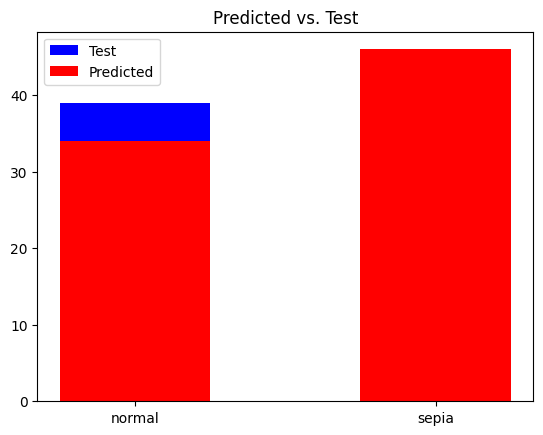

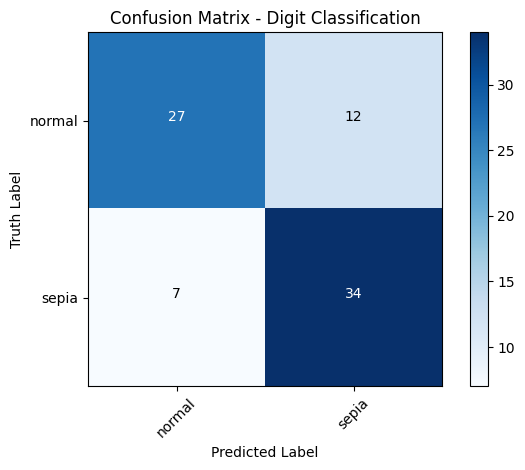

Accuracy: 0.7625
Precision: {'normal': 0.7941176470588235, 'sepia': 0.7391304347826086}
Recall: {'normal': 0.6923076923076923, 'sepia': 0.8292682926829268}


In [37]:
main_sepia(clf)

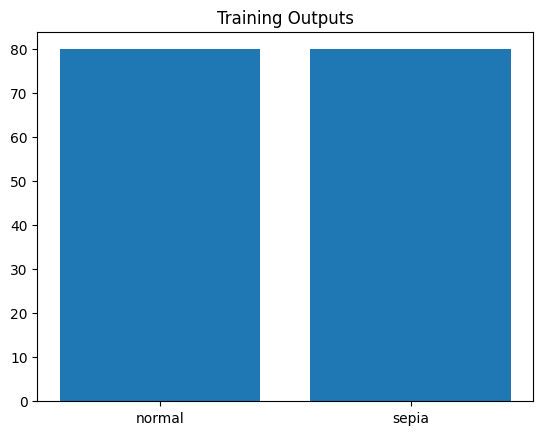

/home/culbec/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-04-24 16:23:48.097546: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   134,218,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,241,090 (512.09 MB)

 Trainable params: 134,239,874 (512.08 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/25


2024-04-24 16:23:50.192464: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1342177280 exceeds 10% of free system memory.
2024-04-24 16:23:50.901208: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1342177280 exceeds 10% of free system memory.
2024-04-24 16:23:51.378912: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1342177280 exceeds 10% of free system memory.
2024-04-24 16:23:58.795554: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1342177280 exceeds 10% of free system memory.
2024-04-24 16:23:58.795872: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1342177280 exceeds 10% of free system memory.


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.4812 - loss: 1.4011
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.6875 - loss: 3.1728
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.6187 - loss: 3.9158
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.8500 - loss: 0.4516
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.8562 - loss: 0.4892
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.9375 - loss: 0.1776
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.9688 - loss: 0.0902
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.9875 - loss: 0.0572
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.9875 - loss: 0.0466
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.9812 - loss: 0.0423
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 1.0000 - loss: 0.0303
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.9812 - loss: 0.0493
Epoch 13/25


AttributeError: 'list' object has no attribute 'tolist'

In [40]:
main_sepia_cnn()